## TP Neural Networks

The architecture of this code is freely inspired from the torch and pytorch architectures, and some sample of code are re-used. It is however designed to be as concise as possible, not in any case for efficiency or flexibility (i.e. if you ever want to do Deep Learning out of this class, don't try to adapt this code, use an existing framework)

## 0. A simple MLP implementation

As always some useful imports:

In [1]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

%matplotlib inline 
# to display directly in the notebook

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

import scipy.ndimage as ndimage
# one of several python libraries for image procession

import scipy.io as sio
# usefull for loading mat files

from sklearn.metrics import confusion_matrix
# Compute confusion matrix

import scipy.optimize as optimize
# usefull for optimization

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

import gzip
#import cPickle # -> for python2
import pickle  # -> for python3
import os
import os.path
from six.moves import urllib

We will consider a Neural Network as a modular architecture, all layer and loss being a Module. We define the Linear, ReLU layers, necessary to implement a MLP, as well as a simple 2-layer MLP and the least square loss function, LeastSquareCriterion.

In [54]:
import math
import numpy as np

class Module(object):
    def __init__(self):
        self.gradInput=None 
        self.output=None
        
    def forward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensionnal array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batchSize,in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = math.sqrt(1. / (out_features* in_features)) * np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight = None
        self.gradBias = None
        
    def forward(self, x):
        self.output = np.dot(x,self.weight.transpose()) + np.repeat(self.bias.reshape([1,-1]), x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self, lr, wd=0):
        self.weight = self.weight - lr * (self.gradWeight + wd * self.weight)
        self.weight = self.weight - lr * self.gradWeight
        self.bias = self.bias - lr * self.gradBias
        

class ReLU(Module):
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput
    

class MLP(Module):

    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self, lr, wd):
        self.fc2.gradientStep(lr, wd)
        self.fc1.gradientStep(lr, wd)
        return True

## 1. Training a neural network

To train a network, we will need data. Download the [MNIST data](http://deeplearning.net/data/mnist/mnist.pkl.gz) (~15Mo). I consists of 28x28 images (loaded as a 784 vector) and the associated label for training, validation and test sets. For this TP, you can focus on the training and validation sets.

5


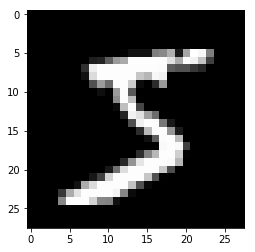

In [4]:
# Load the dataset
f = gzip.open('C:/Users/Adrien/Desktop/M1 ENS/Vision/mnist.pkl.gz', 'rb')
train_set, val_set, test_set = pickle.load(f, encoding='latin1') # python 3
# train_set, val_set, test_set = cPickle.load(f) # python 2
f.close()
train_data=train_set[0]
train_labels=train_set[1]
val_data=val_set[0]
val_labels=val_set[1]
N_train=train_data.shape[1]
N_val=val_data.shape[1]
# check data makes sense
plt.imshow(train_data[0,:].reshape(28,28))
print(train_labels[0])

0/ Read and understand the code provided above

1/ Write a simple loop to train 50 iterations of the MLP defined in 0 with a learning rate 0.001 and batches of size 16.

In [5]:
lr = 0.001
batch_size = 16
nb_iter = 50
nb_classes = 10

In [55]:
def train_model(model, criterion, nb_iter, batch_size, lr, train_data, train_labels, display_loss=False, wd=0):
    
    nb_train_data = train_data.shape[0]

    loss_vec = []
    accuracy_vec = []
    accuracy = 0
    
    for it in range(nb_iter):
        
        rand_idx = np.random.permutation(nb_train_data)[:batch_size]
        batch_data = train_data[rand_idx]
        batch_labels = train_labels[rand_idx]

        output = model.forward(batch_data)

        output_pred = np.array([out.argmax() for out in output])
        for j in range(batch_size):
            if output_pred[j] == batch_labels[j]:
                accuracy += 1

        loss = criterion.forward(output, batch_labels)
        grad = criterion.backward(output, batch_labels)

        model.backward(batch_data, grad)
        model.gradientStep(lr, wd)
        
        if it % 10 == 0:
            loss_vec.append(loss)
            accuracy = (accuracy * 100) / (batch_size * 10)
            accuracy_vec.append(accuracy)
            accuracy = 0
        
        if display_loss:
            print('Itération', it, ':  loss=', loss)
                
    return model, loss_vec, accuracy_vec

mlp = MLP(nb_classes)
criterion = LeastSquareCriterion(nb_classes)

mlp_trained, loss_vec, accuracy_vec = train_model(mlp, criterion, nb_iter, batch_size, lr, train_data, train_labels)

2/ Evaluate the resulting model on the training and validation data. Check visually the quality of the results.

In [12]:
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = (1 - accuracy)
    
    accuracy *= 100
    misclass *= 100

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

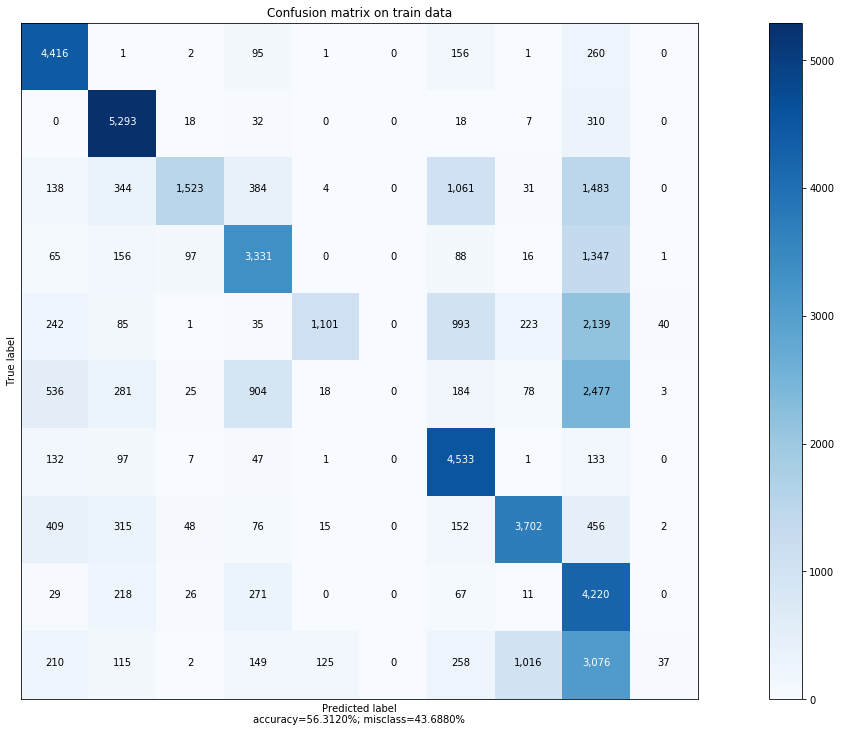

In [16]:
def test_model(model, data, labels, title=None):
    pred_labels = []
    
    batch_size = 16
    nb_data = data.shape[0]
    nb_batch = int(nb_data / batch_size)

    for i in range(nb_batch):
        batch_data = data[i * batch_size : i * batch_size + batch_size]
        batch_labels = labels[i * batch_size : i * batch_size + batch_size]

        pred_batch_labels = model.forward(batch_data)
        pred_labels += [pred.argmax() for pred in pred_batch_labels]

    conf_matrix = confusion_matrix(labels, pred_labels)
    
    if title != None:
        plot_confusion_matrix(cm = conf_matrix, normalize = False, target_names = [], title = title)
    
    accuracy = (np.trace(conf_matrix) * 100) / float(np.sum(conf_matrix))
    
    return accuracy
    
_ = test_model(mlp_trained, train_data, train_labels, title='Confusion matrix on train data')
_ = test_model(mlp_trained, val_data, val_labels, title='Confusion matrix on validation data')

3/ Plot the training and validation losses and accuracies during the training of question 1. (note: you don't have to test your network at every iteration, you can for example do it every 10 iterations)

In [9]:
def plot_loss_accuracy(loss_vec, accuracy_vec):
        
    trace_loss = go.Scatter(
        x = np.linspace(1, len(loss_vec), len(loss_vec)),
        y = np.array(loss_vec),
        mode = 'lines',
        name = 'loss'
    )

    trace_accuracy = go.Scatter(
        x = np.linspace(1, len(accuracy_vec), len(accuracy_vec)),
        y = np.array(accuracy_vec),
        mode = 'lines',
        name = 'accuracy'
    )

    layout = go.Layout(
        title= 'Loss and accuracy evolution on training'
    )

    #Affichage la courbe des erreurs
    plotly.offline.iplot(go.Figure(data=[trace_loss, trace_accuracy], layout=layout))
    
plot_loss_accuracy(loss_vec, accuracy_vec)

4/ Design a training procedure that optimize the training loss (decide for a learning rate, batch size...)

In [23]:
def test_parameters_MLP(nb_iter, batch_size, lr, train_data, train_labels):
    mlp = MLP(nb_classes)
    criterion = LeastSquareCriterion(nb_classes)
    
    mlp_trained, loss_vec, accuracy_vec = train_model(mlp, criterion, nb_iter, batch_size, lr, train_data, train_labels)
    
    accuracy = test_model(mlp_trained, train_data, train_labels)
    
    print('NB iter:', nb_iter, '| batch size:', batch_size, '| learning rate:', lr, '| Accuracy =', accuracy, '%')

# Variation du nombre d'itérations

print('=== Variation du nombre d\'itérations ===')
test_parameters_MLP(50, 16, 0.001, train_data, train_labels)
test_parameters_MLP(100, 16, 0.001, train_data, train_labels)
test_parameters_MLP(500, 16, 0.001, train_data, train_labels)
test_parameters_MLP(1000, 16, 0.001, train_data, train_labels)
test_parameters_MLP(3000, 16, 0.001, train_data, train_labels)
test_parameters_MLP(5000, 16, 0.001, train_data, train_labels)
print('\n')

print('=== Variation du batch size ===')
test_parameters_MLP(1000, 8, 0.001, train_data, train_labels)
test_parameters_MLP(1000, 16, 0.001, train_data, train_labels)
test_parameters_MLP(1000, 32, 0.001, train_data, train_labels)
test_parameters_MLP(1000, 64, 0.001, train_data, train_labels)
test_parameters_MLP(1000, 128, 0.001, train_data, train_labels)
print('\n')

print('=== Variation du learning rate ===')
test_parameters_MLP(1000, 32, 0.001, train_data, train_labels)
test_parameters_MLP(1000, 32, 0.005, train_data, train_labels)
test_parameters_MLP(1000, 32, 0.01, train_data, train_labels)
test_parameters_MLP(1000, 32, 0.05, train_data, train_labels)
print('\n')

print('=== Aumentation du batch size et learning rate ===')
test_parameters_MLP(1000, 64, 0.005, train_data, train_labels)
test_parameters_MLP(1000, 128, 0.005, train_data, train_labels)
test_parameters_MLP(1000, 64, 0.01, train_data, train_labels)
test_parameters_MLP(1000, 128, 0.01, train_data, train_labels)

=== Variation du nombre d'itérations ===
NB iter: 100 | batch size: 16 | learning rate: 0.001 | Accuracy = 71.386 %
NB iter: 500 | batch size: 16 | learning rate: 0.001 | Accuracy = 81.514 %
NB iter: 1000 | batch size: 16 | learning rate: 0.001 | Accuracy = 84.722 %
NB iter: 3000 | batch size: 16 | learning rate: 0.001 | Accuracy = 90.36 %
NB iter: 5000 | batch size: 16 | learning rate: 0.001 | Accuracy = 91.72 %
NB iter: 10000 | batch size: 16 | learning rate: 0.001 | Accuracy = 93.936 %


=== Variation du batch size ===
NB iter: 1000 | batch size: 8 | learning rate: 0.001 | Accuracy = 80.898 %
NB iter: 1000 | batch size: 16 | learning rate: 0.001 | Accuracy = 86.14 %
NB iter: 1000 | batch size: 32 | learning rate: 0.001 | Accuracy = 88.69 %
NB iter: 1000 | batch size: 64 | learning rate: 0.001 | Accuracy = 91.33 %
NB iter: 1000 | batch size: 128 | learning rate: 0.001 | Accuracy = 93.14 %


=== Variation du learning rate ===
NB iter: 1000 | batch size: 32 | learning rate: 0.001 | Acc

Il semble qu'il y a un compromis à trouver entre augmentation de la taille du batch et augmentation du learning rate. Les meilleurs paramètre trouvés sont alors:

nb_iter = 5000, batch_size = 64, learning_rate = 0.005

Augmenter le nombre d'itération permet d'encore augmenter les performances.

In [28]:
def test_MLP(nb_iter, batch_size, lr, train_data, train_labels, val_data, val_labels):
    
    mlp = MLP(nb_classes)
    criterion = LeastSquareCriterion(nb_classes)
    
    mlp_trained, loss_vec, accuracy_vec = train_model(mlp, criterion, nb_iter, batch_size, lr, train_data, train_labels)
    
    test_model(mlp_trained, train_data, train_labels, title='Confusion matrix on train data')
    test_model(mlp_trained, val_data, val_labels, title='Confusion matrix on validation data')
    
    plot_loss_accuracy(loss_vec, accuracy_vec)

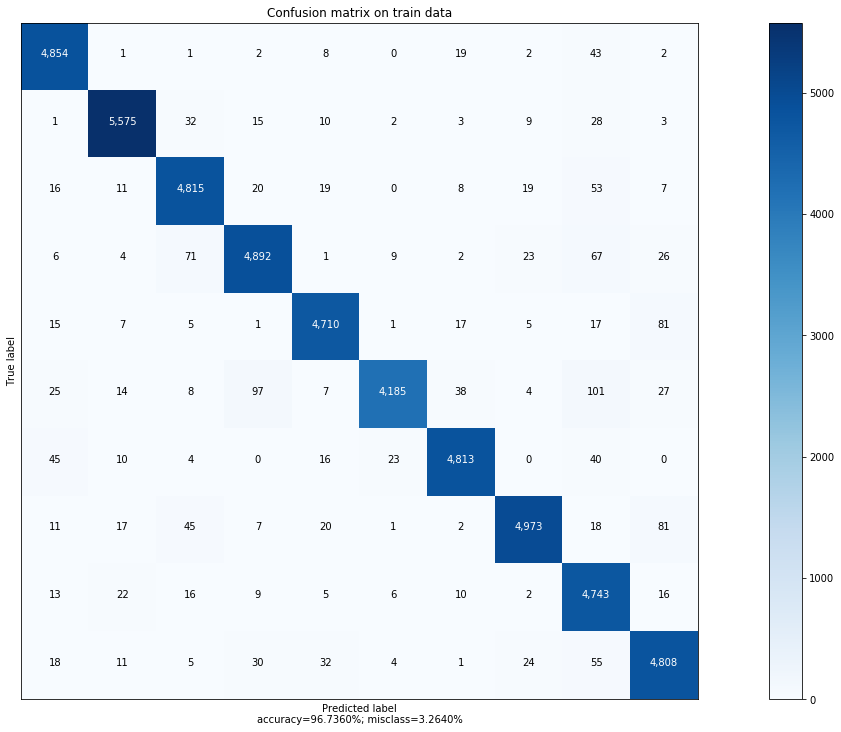

In [29]:
# Best parameters
test_MLP(5000, 64, 0.005, train_data, train_labels, val_data, val_labels)

## 2. Overfitting

1/ What's the number of parameters in the network of 1?

Le premier réseau a $(784 * 64) + 64 + (64 * 10) + 10 = 50890$ paramètres.

2/ Add a parameter to vary the size of the intermediate layer. Design a second type of MLP with 3 linear layers, and parameters for the sizes of the two intermediate layers. (test the associates function)

In [56]:
class MLP_3_layer(Module):

    def __init__(self, num_classes=10, h_dim1=128, h_dim2=32):
        super(MLP_3_layer, self).__init__()
        self.fc1 = Linear(784, h_dim1)
        self.relu1 = ReLU()
        self.fc2 = Linear(h_dim1, h_dim2)
        self.relu2 = ReLU()
        self.fc3 = Linear(h_dim2, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.relu2.output, gradient)
        gradient = self.relu2.backward(self.fc2.output, gradient)
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr, wd):
        self.fc3.gradientStep(lr, wd)
        self.fc2.gradientStep(lr, wd)
        self.fc1.gradientStep(lr, wd)
        return True

In [39]:
def test_parameters_MLP_3_layer(h_dim1, h_dim2, train_data, train_labels):
    nb_iter = 1000
    batch_size = 64
    lr = 0.005
    
    mlp = MLP_3_layer(nb_classes, h_dim1, h_dim2)
    criterion = LeastSquareCriterion(nb_classes)
    
    mlp_trained, loss_vec, accuracy_vec = train_model(mlp, criterion, nb_iter, batch_size, lr, train_data, train_labels)    
    accuracy = test_model(mlp_trained, train_data, train_labels)
    
    print('Hidden dim 1:', h_dim1, '| Hidden dim 2:', h_dim2, '| Accuracy =', accuracy, '%')
    
test_parameters_MLP_3_layer(512, 256, train_data, train_labels)
test_parameters_MLP_3_layer(512, 128, train_data, train_labels)
test_parameters_MLP_3_layer(512, 64, train_data, train_labels)
test_parameters_MLP_3_layer(512, 32, train_data, train_labels)
print('\n')

test_parameters_MLP_3_layer(256, 128, train_data, train_labels)
test_parameters_MLP_3_layer(256, 64, train_data, train_labels)
test_parameters_MLP_3_layer(256, 32, train_data, train_labels)
test_parameters_MLP_3_layer(256, 16, train_data, train_labels)
print('\n')

test_parameters_MLP_3_layer(128, 100, train_data, train_labels)
test_parameters_MLP_3_layer(128, 64, train_data, train_labels)
test_parameters_MLP_3_layer(128, 32, train_data, train_labels)
test_parameters_MLP_3_layer(128, 16, train_data, train_labels)
print('\n')

test_parameters_MLP_3_layer(64, 50, train_data, train_labels)
test_parameters_MLP_3_layer(64, 32, train_data, train_labels)
test_parameters_MLP_3_layer(64, 16, train_data, train_labels)
print('\n')

Hidden dim 1: 512 | Hidden dim 2: 256 | Accuracy = 95.358 %
Hidden dim 1: 512 | Hidden dim 2: 128 | Accuracy = 95.302 %
Hidden dim 1: 512 | Hidden dim 2: 64 | Accuracy = 95.486 %
Hidden dim 1: 512 | Hidden dim 2: 32 | Accuracy = 95.648 %
Hidden dim 1: 256 | Hidden dim 2: 128 | Accuracy = 95.364 %
Hidden dim 1: 256 | Hidden dim 2: 64 | Accuracy = 95.556 %
Hidden dim 1: 256 | Hidden dim 2: 32 | Accuracy = 95.542 %
Hidden dim 1: 256 | Hidden dim 2: 16 | Accuracy = 95.358 %
Hidden dim 1: 128 | Hidden dim 2: 100 | Accuracy = 94.982 %
Hidden dim 1: 128 | Hidden dim 2: 64 | Accuracy = 95.396 %
Hidden dim 1: 128 | Hidden dim 2: 32 | Accuracy = 95.218 %
Hidden dim 1: 128 | Hidden dim 2: 16 | Accuracy = 95.508 %
Hidden dim 1: 64 | Hidden dim 2: 50 | Accuracy = 94.794 %
Hidden dim 1: 64 | Hidden dim 2: 32 | Accuracy = 94.878 %
Hidden dim 1: 64 | Hidden dim 2: 16 | Accuracy = 94.296 %


In [40]:
def test_MLP_3_layer(nb_iter, batch_size, lr, h_dim1, h_dim2, train_data, train_labels, val_data, val_labels):
    
    mlp = MLP_3_layer(nb_classes, h_dim1, h_dim2)
    criterion = LeastSquareCriterion(nb_classes)
    
    mlp_trained, loss_vec, accuracy_vec = train_model(mlp, criterion, nb_iter, batch_size, lr, train_data, train_labels)
    
    test_model(mlp_trained, train_data, train_labels, title='Confusion matrix on train data')
    test_model(mlp_trained, val_data, val_labels, title='Confusion matrix on validation data')
    
    plot_loss_accuracy(loss_vec, accuracy_vec)
    
test_MLP_3_layer(20000, 64, 0.005, 512, 32, train_data, train_labels, val_data, val_labels)

3/ Keeping the training procedure fixed, test different size of networks and layers. Show evidence of overfitting.

In [57]:
class MLP_deep(Module):

    def __init__(self, num_classes=10, h_dims=[64]):
        super(MLP_deep, self).__init__()
        
        self.fcs = []
        self.relus = []
        
        self.fcs.append(Linear(784, h_dims[0]))
        self.relus.append(ReLU())
        
        for i in range(0, len(h_dims) - 1):
            self.fcs.append(Linear(h_dims[i], h_dims[i + 1]))
            self.relus.append(ReLU())
        
        self.fcs.append(Linear(h_dims[-1], 10))
    
    def forward(self, x):
        for i in range(len(self.fcs) - 1):
            x = self.fcs[i].forward(x)
            x = self.relus[i].forward(x)
        
        x = self.fcs[-1].forward(x)
        
        return x
    
    def backward(self, x, gradient):
        for i in range(len(self.fcs) - 1, 0, -1):
            gradient = self.fcs[i].backward(self.relus[i - 1].output, gradient)
            gradient = self.relus[i - 1].backward(self.fcs[i - 1].output, gradient)
        
        gradient = self.fcs[0].backward(x, gradient)
    
        return gradient
    
    def gradientStep(self, lr, wd):
        for fc in self.fcs:
            fc.gradientStep(lr, wd)
            
        return True

In [49]:
def test_parameters_MLP_deep(h_dims, train_data, train_labels, val_data, val_labels):
    nb_iter = 5000
    batch_size = 64
    lr = 0.005
    
    mlp = MLP_deep(nb_classes, h_dims)
    criterion = LeastSquareCriterion(nb_classes)
    
    mlp_trained, loss_vec, accuracy_vec = train_model(mlp, criterion, nb_iter, batch_size, lr, train_data, train_labels)    
    
    train_accuracy = test_model(mlp_trained, train_data, train_labels)
    test_accuracy = test_model(mlp_trained, val_data, val_labels)
    
    print('Hidden dimensions:', h_dims, '| Train Accuracy =', train_accuracy, '%', '| Test Accuracy =', test_accuracy, '%')

test_parameters_MLP_deep([512, 16], train_data, train_labels, val_data, val_labels)
print('\n')

test_parameters_MLP_deep([512, 256, 64], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([512, 256, 32], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([512, 256, 16], train_data, train_labels, val_data, val_labels)
print('\n')

test_parameters_MLP_deep([512, 128, 16], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([512, 64, 16], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([512, 32, 16], train_data, train_labels, val_data, val_labels)
print('\n')

test_parameters_MLP_deep([256, 128, 64], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([256, 128, 32], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([256, 128, 16], train_data, train_labels, val_data, val_labels)
print('\n')

test_parameters_MLP_deep([256, 64, 32], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([256, 64, 16], train_data, train_labels, val_data, val_labels)
print('\n')

test_parameters_MLP_deep([128, 64, 32], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([128, 64, 16], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([128, 32, 16], train_data, train_labels, val_data, val_labels)
print('\n')

test_parameters_MLP_deep([512, 256, 128, 64], train_data, train_labels, val_data, val_labels)
test_parameters_MLP_deep([512, 256, 64, 16], train_data, train_labels, val_data, val_labels)

Hidden dimensions: [512, 16] | Train Accuracy = 99.128 % | Test Accuracy = 98.12 %


Hidden dimensions: [512, 256, 64] | Train Accuracy = 98.262 % | Test Accuracy = 97.47 %
Hidden dimensions: [512, 256, 32] | Train Accuracy = 98.658 % | Test Accuracy = 97.58 %
Hidden dimensions: [512, 256, 16] | Train Accuracy = 98.778 % | Test Accuracy = 97.89 %


Hidden dimensions: [512, 128, 16] | Train Accuracy = 98.786 % | Test Accuracy = 97.72 %
Hidden dimensions: [512, 64, 16] | Train Accuracy = 98.73 % | Test Accuracy = 97.76 %
Hidden dimensions: [512, 32, 16] | Train Accuracy = 99.052 % | Test Accuracy = 97.91 %


Hidden dimensions: [256, 128, 64] | Train Accuracy = 98.434 % | Test Accuracy = 97.6 %
Hidden dimensions: [256, 128, 32] | Train Accuracy = 98.598 % | Test Accuracy = 97.61 %
Hidden dimensions: [256, 128, 16] | Train Accuracy = 98.728 % | Test Accuracy = 97.58 %


Hidden dimensions: [256, 64, 32] | Train Accuracy = 98.838 % | Test Accuracy = 97.58 %
Hidden dimensions: [256, 64, 16] |

In [50]:
# def test_MLP_deep(nb_iter, batch_size, lr, h_dims, train_data, train_labels, val_data, val_labels):
    
#     mlp = MLP_deep(nb_classes, h_dims)
#     criterion = LeastSquareCriterion(nb_classes)
    
#     mlp_trained, loss_vec, accuracy_vec = train_model(mlp, criterion, nb_iter, batch_size, lr, train_data, train_labels)
    
#     test_model(mlp_trained, train_data, train_labels, title='Confusion matrix on train data')
#     test_model(mlp_trained, val_data, val_labels, title='Confusion matrix on validation data')
    
#     plot_loss_accuracy(loss_vec, accuracy_vec)
    
# #test_MLP_deep(20000, 64, 0.005, [64, 50, 32], train_data, train_labels, val_data, val_labels)

4/ Add an optionnal parameter for weight decay (in the gradientStep functions) and show that it can reduce overfitting in some cases (improving the validation performance may be hard, you would have to look at a setting with very little training data to see, you can focus on showing that the gap between training and validation performance decreases)

In [63]:
def test_MLP_with_weigth_decay(wd, train_data, train_labels, val_data, val_labels):
    nb_iter = 5000
    batch_size = 64
    lr = 0.005
    h_dims = [512, 16]
    
    mlp = MLP_deep(nb_classes, h_dims)
    criterion = LeastSquareCriterion(nb_classes)
    
    mlp_trained, loss_vec, accuracy_vec = train_model(
        mlp, criterion, nb_iter, batch_size, lr, train_data, train_labels, False, wd)    
    
    train_accuracy = test_model(mlp_trained, train_data, train_labels)
    test_accuracy = test_model(mlp_trained, val_data, val_labels)
    
    print('Weight decay:', wd, '| Train Accuracy =', train_accuracy, '%', '| Test Accuracy =', test_accuracy, '%')

test_MLP_with_weigth_decay(0, train_data, train_labels, val_data, val_labels)
test_MLP_with_weigth_decay(0.1, train_data, train_labels, val_data, val_labels)
test_MLP_with_weigth_decay(0.2, train_data, train_labels, val_data, val_labels)
test_MLP_with_weigth_decay(0.3, train_data, train_labels, val_data, val_labels)
test_MLP_with_weigth_decay(0.4, train_data, train_labels, val_data, val_labels)
test_MLP_with_weigth_decay(0.5, train_data, train_labels, val_data, val_labels)

Weight decay: 0 | Train Accuracy = 98.894 % | Test Accuracy = 98.06 %
Weight decay: 0.1 | Train Accuracy = 98.018 % | Test Accuracy = 97.55 %
Weight decay: 0.2 | Train Accuracy = 97.336 % | Test Accuracy = 97.25 %
Weight decay: 0.3 | Train Accuracy = 96.638 % | Test Accuracy = 96.69 %
Weight decay: 0.4 | Train Accuracy = 95.148 % | Test Accuracy = 95.49 %
Weight decay: 0.5 | Train Accuracy = 95.086 % | Test Accuracy = 95.27 %


## 3. Optionnal

The following questions are optionnal and do not have a specific order! 

1/ Add some momentum to your training procedure. How does it change the training behavior?

2/ Implement and test different loss functions (L1, Cross-Entropy)

3/ Implement and test different non-linearities

4/ (longer/harder) Implement and test layers that consider the 2D structure of the input data (max pooling, convolution)